In [67]:
# 標準ライブラリ
import gc
import os
import pickle
import random
import sys
import warnings
from itertools import combinations, permutations
from pathlib import Path

# サードパーティのライブラリ
import category_encoders as ce
import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
import polars as pl
import scipy as sp
import seaborn as sns
import torch
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from dateutil.relativedelta import relativedelta
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, log_loss, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import (GroupKFold, KFold, StratifiedKFold,
                                     StratifiedGroupKFold, TimeSeriesSplit,
                                     train_test_split)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

import glob

In [68]:
class CFG:
    home_directory = os.path.expanduser('~/kaggle_HomeCredit/')
    kaggle_directory = os.path.expanduser('/kaggle/input/home-credit-credit-risk-model-stability/')
    
    train_data_path = os.path.join(home_directory, 'train/')
    test_data_path = os.path.join(home_directory, 'test/')
    
    OOF_DATA_PATH = Path(home_directory) / 'oof'
    MODEL_DATA_PATH = Path(home_directory) / 'models'
    SUB_DATA_PATH = Path(home_directory) / 'submission'

    def __init__(self):
        self.create_directories()
    
    def create_directories(self):
        for path in [self.OOF_DATA_PATH, self.MODEL_DATA_PATH, self.SUB_DATA_PATH]:
            path.mkdir(parents=True, exist_ok=True)
    
    
    VER = 'Adversarial_Validation'
    AUTHOR = 'Mira'
    COMPETITION = 'HomeCredit'

    METHOD_LIST = ['lightgbm']
    seed = 28
    n_folds = 5
    target_col = 'target'
    adv_target_col = 'adv_target'
    metric = 'auc'
    
    metric_maximize_flag = True
    num_boost_round = 500
    early_stopping_round = 200
    verbose = 25
    classification_lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'seed': seed,
        #"device_type": "gpu",
    }
    classification_xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.05,
        'random_state': seed,
        "tree_method": "gpu_hist",
    }

    classification_cat_params = {
        'learning_rate': 0.05,
        'iterations': num_boost_round,
        'random_seed': seed,
        "task_type": "GPU",
    }
    model_weight_dict = {'lightgbm': 1}
    

class is_kaggle:
    def __init__(self, Kaggle):
        if Kaggle == "Yes":
            self.path = Path(CFG.kaggle_directory)
        else:
            self.path = Path(CFG.home_directory)

In [69]:
selector = is_kaggle("No")
cfg_instance = CFG()

In [70]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [71]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [72]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob.glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    return df

In [73]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [74]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [75]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [76]:
ROOT = selector.path
TRAIN_DIR       = ROOT / "parquet_files/train"
TEST_DIR        = ROOT / "parquet_files/test"
SAMPLE_SUB = ROOT / "sample_submission.csv"

In [77]:
train_data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [78]:
test_data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [79]:
df_train = feature_eng(**train_data_store)
print("train data shape:\t", df_train.shape)
df_test = feature_eng(**test_data_store)
print("train data shape:\t", df_test.shape)

train data shape:	 (1526659, 472)
train data shape:	 (10, 471)


In [80]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 361)
test data shape:	 (10, 360)


In [81]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [82]:
del train_data_store,test_data_store
gc.collect()

1692

In [83]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 3159.43 MB
Memory usage after optimization is: 1191.00 MB
Decreased by 62.3%
Memory usage of dataframe is 0.03 MB
Memory usage after optimization is: 0.02 MB
Decreased by 25.0%


In [84]:
df_train['target'].value_counts()

0    1478665
1      47994
Name: target, dtype: int64

In [85]:
X_train = df_train.drop(['target'], axis=1)

X_train['adv_target'] = 0
df_test['adv_target'] = 1
train_test_adv = pd.concat([X_train, df_test], axis=0).reset_index(drop=True)

In [86]:
def encoder(df):
    object_columns = [col for col in df.columns if df[col].dtype.name == 'object' or df[col].dtype.name == 'category']
    
    bool_columns = [col for col in df.columns if df[col].dtype == 'bool']

    for col in object_columns:
        df[col] = df[col].astype('category')
        
    for col in bool_columns:
        df[col] = df[col].astype(int)
    return df
train_test_adv = encoder(train_test_adv)

--------------------------------------------------
training fold 1
[LightGBM] [Info] Number of positive: 8, number of negative: 1221327
[LightGBM] [Info] Total Bins 45745
[LightGBM] [Info] Number of data points in the train set: 1221335, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.936007
[LightGBM] [Info] Start training from score -11.936007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

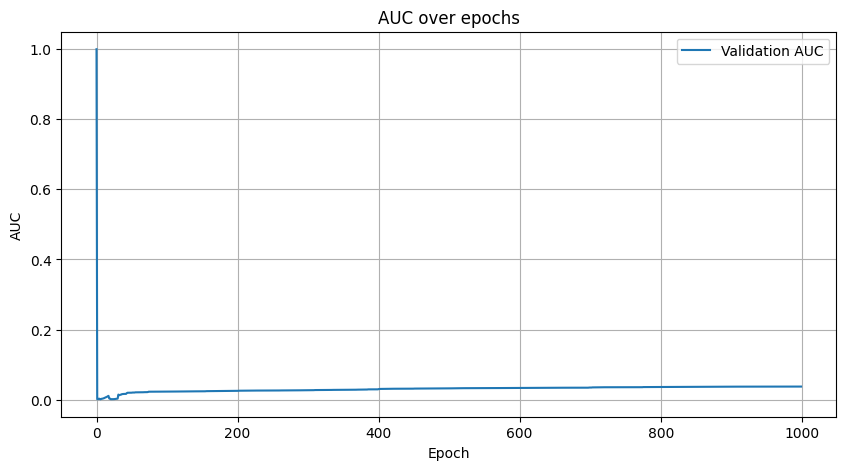

--------------------------------------------------
training fold 2
[LightGBM] [Info] Number of positive: 8, number of negative: 1221327
[LightGBM] [Info] Total Bins 45787
[LightGBM] [Info] Number of data points in the train set: 1221335, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.936007
[LightGBM] [Info] Start training from score -11.936007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

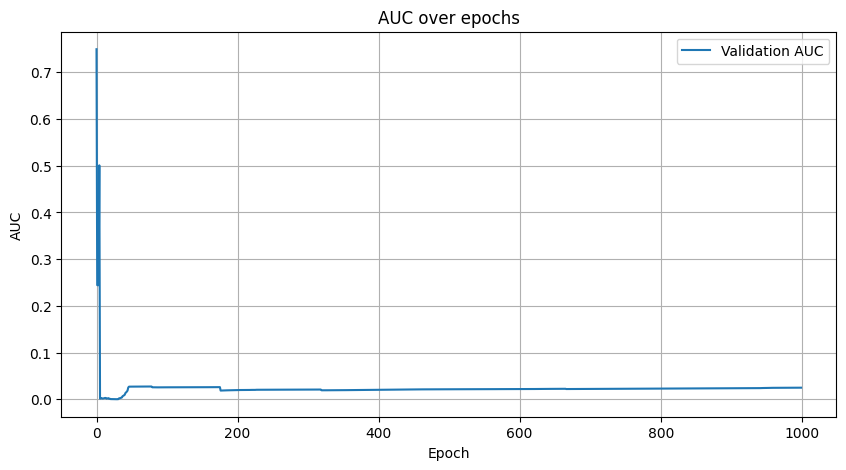

--------------------------------------------------
training fold 3
[LightGBM] [Info] Number of positive: 8, number of negative: 1221327
[LightGBM] [Info] Total Bins 45776
[LightGBM] [Info] Number of data points in the train set: 1221335, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.936007
[LightGBM] [Info] Start training from score -11.936007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

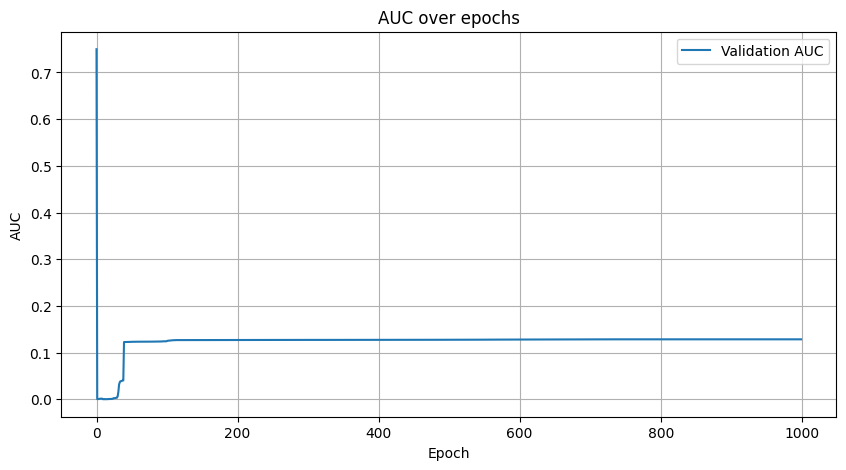

--------------------------------------------------
training fold 4
[LightGBM] [Info] Number of positive: 8, number of negative: 1221327
[LightGBM] [Info] Total Bins 45741
[LightGBM] [Info] Number of data points in the train set: 1221335, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.936007
[LightGBM] [Info] Start training from score -11.936007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

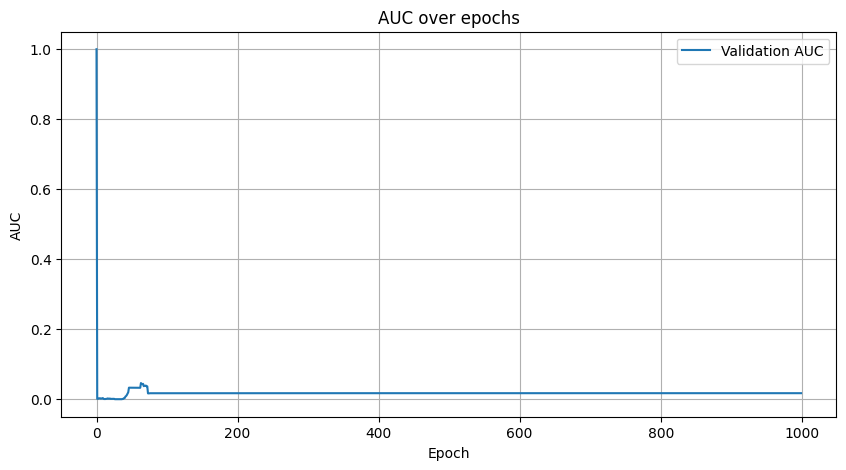

--------------------------------------------------
training fold 5
[LightGBM] [Info] Number of positive: 8, number of negative: 1221328
[LightGBM] [Info] Total Bins 45728
[LightGBM] [Info] Number of data points in the train set: 1221336, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.936008
[LightGBM] [Info] Start training from score -11.936008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

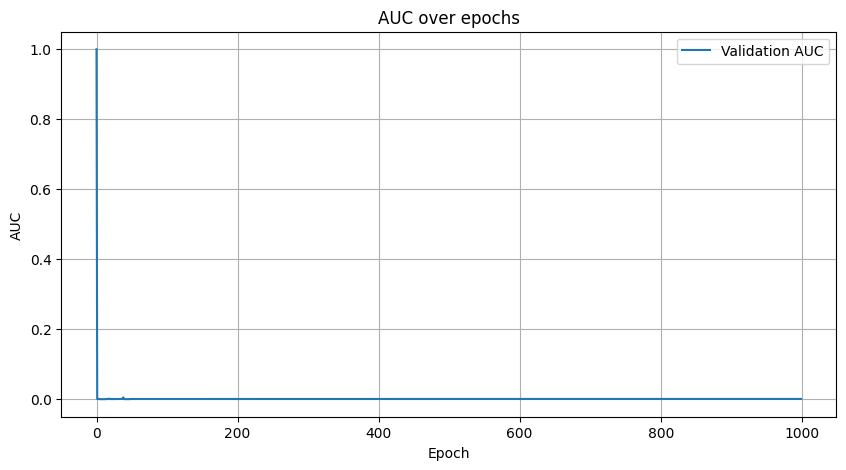

In [87]:
cv = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True,random_state=CFG.seed)
features = [i for i in train_test_adv.columns if i != ['WEEK_NUM','case_id','adv_target']]
weeks = train_test_adv['WEEK_NUM']
evals_result = {}
evals_results = []

for fold, (train_index, valid_index) in enumerate(cv.split(train_test_adv, train_test_adv[CFG.adv_target_col])):
    print('-'*50)
    print(f'training fold {fold+1}')

    x_train = train_test_adv[features].iloc[train_index]
    y_train = train_test_adv[CFG.adv_target_col].iloc[train_index]
    x_valid = train_test_adv[features].iloc[valid_index]
    y_valid = train_test_adv[CFG.adv_target_col].iloc[valid_index]

    lgb_params = {
        'objective': 'binary',
        'n_estimators':1000,
        'metric': 'auc',
        'learning_rate': 0.05,
        'seed': 28,
        'force_col_wise':True
    }
    model = lgb.LGBMClassifier(**lgb_params)
    evals_result = {} 
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric='auc',
    )

    evals_result = model.evals_result_  
    epochs = range(len(evals_result['valid_0']['auc'])) 
    auc_scores = evals_result['valid_0']['auc']

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, auc_scores, label='Validation AUC') 
    plt.title('AUC over epochs') 
    plt.xlabel('Epoch')
    plt.ylabel('AUC') 
    plt.legend() 
    plt.grid(True) 
    plt.show()  